# Analytics Day 2024: Football Squares

**Class:** Discrete Math  
**Authors:** Joseph & Kareem  
**Date:** 10/9  

---

### **About The Game**
Football Squares is a popular game played during football games, often at parties or gatherings. The game involves a 10x10 grid where each participant buys one or more squares. Each row and column of the grid is assigned a number (0 through 9), corresponding to the last digit of the score for each team. After each quarter, the last digits of the teams' scores are used to find the corresponding square, and the owner of that square wins.

Source: [wikiHow article on Football Squares](https://www.wikihow.com/Play-Football-Squares)

---

### **Data**
This dataset includes 5,412 NFL regular season games from 1994 to 2023, detailing:

- **Team Names & Scoring**:
  - **Home Team**: `home_name`, `home_q1`, `home_q2`, `home_q3`, `home_q4`, `home_final`
  - **Away Team**: `away_name`, `away_q1`, `away_q2`, `away_q3`, `away_q4`, `away_final`
  - Scores are broken down by quarter, with overtime points added to the final score.

- **Season Information**:
  - **Year**: The season year of each game, ranging from 1994 to 2023.
  - **Week**: The specific week within the regular season when the game occurred.
   
Games per season:
- 1994-2001: 240
- 2002-2020: 256
- 2021-2023: 272

Data was collected from [https://www.jt-sw.com/football/boxes/index.nsf](https://www.jt-sw.com/football/boxes/index.nsf) on 10/9.

*Note: The dataset currently has approximately 2,500 games missing. A total of about 7,700 NFL games were played between 1994 and 2023. The dataset will be updated soon to include the full list of games.*

### IMPORTS

In [1]:
import pandas as pd
import numpy as np

games = pd.read_csv("data/nfl box scores.csv")

games_pre94 = pd.read_csv("data/nfl box scores 2.csv")
games_pre94.drop(["home_q5", "away_q5"], axis=1, inplace=True)
games_pre94.rename(columns={'home_team': 'home_name', 'away_team': 'away_name', "season": "year"},
                   inplace=True)
games_pre94 = games_pre94[games_pre94["year"] <= 1993]

games = pd.concat([games_pre94, games], ignore_index=True)

games.head()

,home_name,home_q1,home_q2,home_q3,home_q4,home_final,away_name,away_q1,away_q2,away_q3,away_q4,away_final,year,week
0,Tampa Bay BuccaneersTampa Bay (0-1),7,3,0,3,13,New York GiantsNY Giants (1-0),7,3,6,3,19,1978,1
1,Detroit LionsDetroit (0-1),0,0,7,0,7,Green Bay PackersGreen Bay (1-0),6,0,7,0,13,1978,1
2,Atlanta FalconsAtlanta (1-0),0,14,3,3,20,Houston OilersHouston (0-1),7,0,7,0,14,1978,1
3,Cincinnati BengalsCincinnati (0-1),0,9,0,14,23,Kansas City ChiefsKansas City (1-0),7,10,7,0,24,1978,1
4,Philadelphia EaglesPhiladelphia (0-1),0,0,0,14,14,Los Angeles RamsLos Angeles (1-0),3,3,0,10,16,1978,1


In [2]:
# Cumulative sums per quarter.
df = games.copy()
#df[["home_q2", "home_q3"]] = df.iloc[:, 2:3].cumsum()
for quarter in range(2, 5):
    for home_away in ["home", "away"]:
        df[f"{home_away}_q{quarter}"] = df[f"{home_away}_q{quarter-1}"] + df[f"{home_away}_q{quarter}"]

df_games = df.copy()
df_games.head()

,home_name,home_q1,home_q2,home_q3,home_q4,home_final,away_name,away_q1,away_q2,away_q3,away_q4,away_final,year,week
0,Tampa Bay BuccaneersTampa Bay (0-1),7,10,10,13,13,New York GiantsNY Giants (1-0),7,10,16,19,19,1978,1
1,Detroit LionsDetroit (0-1),0,0,7,7,7,Green Bay PackersGreen Bay (1-0),6,6,13,13,13,1978,1
2,Atlanta FalconsAtlanta (1-0),0,14,17,20,20,Houston OilersHouston (0-1),7,7,14,14,14,1978,1
3,Cincinnati BengalsCincinnati (0-1),0,9,9,23,23,Kansas City ChiefsKansas City (1-0),7,17,24,24,24,1978,1
4,Philadelphia EaglesPhiladelphia (0-1),0,0,0,14,14,Los Angeles RamsLos Angeles (1-0),3,6,6,16,16,1978,1


### WIN PROBABILITIES PER SQUARE PER QUARTER

In [25]:
def winner_winner_chicken_dinner(scores):
    """
    Returns the ones digits of the home and away scores for each quarters 1, 2, and 3, and the final score.

    Parameters:
        scores (pandas.Series): A df row with data from one game.
                       
    Returns:
        tuple: A tuple of tuples, each containing the ones digits for (home, away) in q1, q2, q3, and final.
    """
    q1 = (scores["home_q1"] % 10, scores["away_q1"] % 10)
    q2 = (scores["home_q2"] % 10, scores["away_q2"] % 10)
    q3 = (scores["home_q3"] % 10, scores["away_q3"] % 10)
    final = (scores["home_final"] % 10, scores["away_final"] % 10)
    
    return q1, q2, q3, final


def create_frequency_matrices(df):
    """
    Creates frequency matrices of winning squares for each quarter across all games.

    Parameters:
        df (pd.DataFrame): DataFrame of game data.

    Returns:
        np.ndarray: Shape (4, 10, 10), with a 10x10 matrix for each quarter showing winning square frequencies.
    """
    # create maatrix representing game board
    freq_boards = np.zeros(shape=(4, 10, 10))
    # get winning squares for each game and each quarter
    winners = df.apply(winner_winner_chicken_dinner, axis=1)
    
    # per quarter, update freq for each winning square
    for quarter in range(4):
        # get winners for each quarter for all games
        quarter_ind = np.array([w[quarter] for w in winners])
        
        # build frequencies
        np.add.at(freq_boards[quarter], (quarter_ind[:, 0], quarter_ind[:, 1]), 1)

    # replace zeroes with 1
    freq_boards = np.where(freq_boards == 0, 1, freq_boards)

    
    return freq_boards.astype(int)

def create_fair_value_matrices(mat, board_value):
    # probability matrices
    probability_matrices = np.empty(shape=(4, 10, 10))
    
    for i in range(mat.shape[0]):
            cumulative_sum = mat[i].sum()
            probability_matrices[i] = mat[i] / cumulative_sum
    
    # fair value matrices
    fair_value_matrices = probability_matrices * board_value
    
    return fair_value_matrices
    

print("Helper functions loaded.")

Helper functions loaded.


In [13]:
print("Rows: Home, Columns: Away\n")
frequency_matrices = create_frequency_matrices(df.copy())
fair_value_matrices = create_fair_value_matrices(mat=frequency_matrices, board_value=100)

fair_value_matrices

Rows: Home, Columns: Away



array([[[1.97447193e+01, 2.59798938e-01, 1.24251666e-01, 8.21190557e+00,
         2.33819044e+00, 4.51824240e-02, 1.25381227e+00, 1.05726872e+01,
         1.12956060e-02, 1.80729696e-01],
        [4.40528634e-01, 1.12956060e-02, 1.12956060e-02, 1.12956060e-02,
         3.38868180e-02, 1.12956060e-02, 1.12956060e-02, 1.46842878e-01,
         1.12956060e-02, 1.12956060e-02],
        [2.03320908e-01, 1.12956060e-02, 1.12956060e-02, 3.38868180e-02,
         2.25912120e-02, 1.12956060e-02, 1.12956060e-02, 4.51824240e-02,
         1.12956060e-02, 1.12956060e-02],
        [8.39263526e+00, 7.90692421e-02, 6.77736361e-02, 2.67705862e+00,
         6.66440755e-01, 2.25912120e-02, 3.61459392e-01, 3.61459392e+00,
         1.12956060e-02, 2.25912120e-02],
        [3.27572574e+00, 1.12956060e-02, 4.51824240e-02, 6.21258331e-01,
         9.03648481e-02, 1.12956060e-02, 5.64780300e-02, 1.16344742e+00,
         1.12956060e-02, 1.12956060e-02],
        [3.38868180e-02, 1.12956060e-02, 1.12956060e-02, 1.1

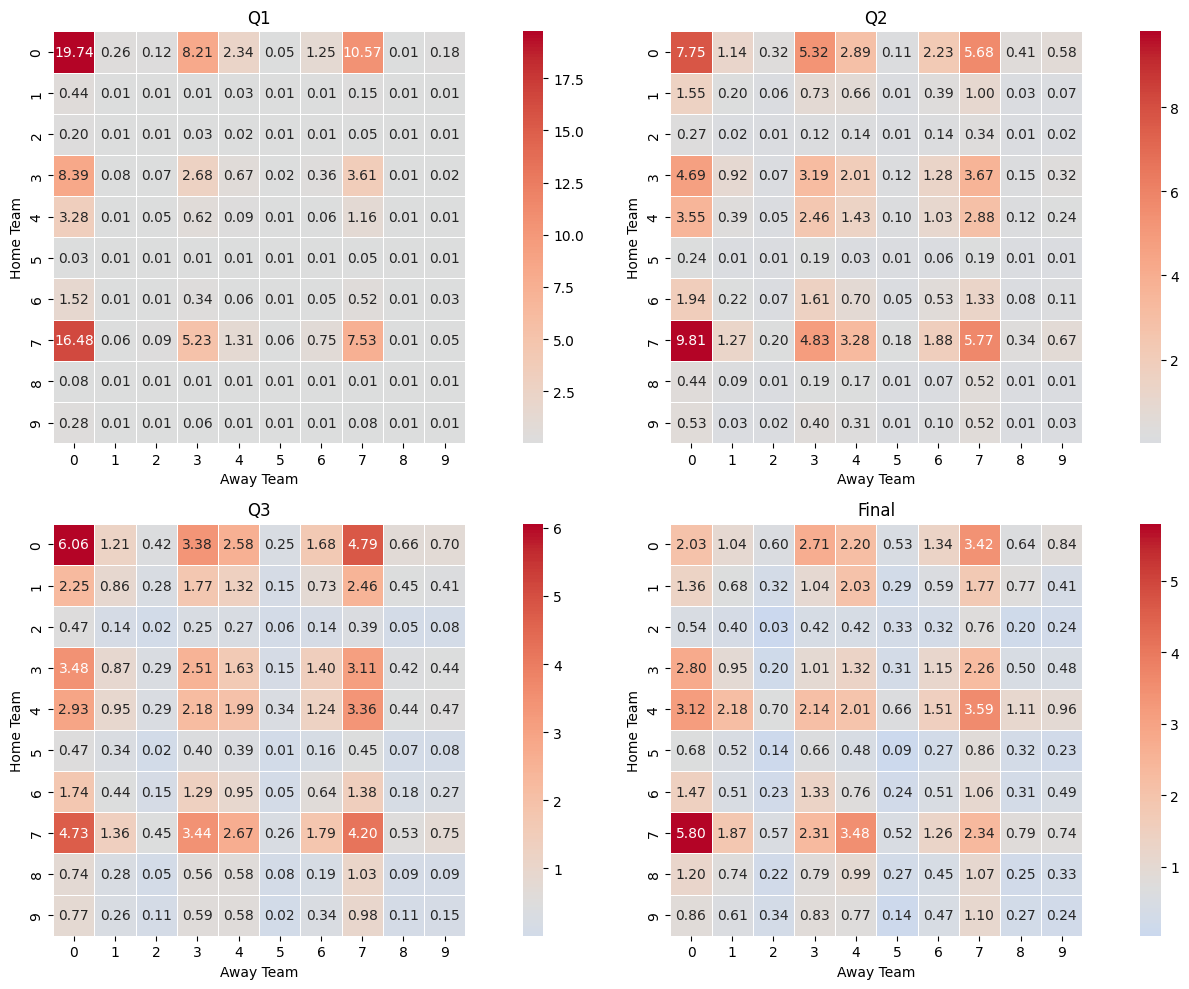

In [103]:
# Heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

quarters = ['Q1', 'Q2', 'Q3', 'Final']
mid_value = np.median(fair_value_matrices, axis=(1, 2))
cmap = "coolwarm"
title = "Win Frequencies Per Quarter for Football Squares"

plt.figure(figsize=(18, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    
    sns.heatmap(fair_value_matrices[i], annot=True, fmt="0.2f", cmap=cmap, center=mid_value[i],
                cbar=True, square=True, linewidths=0.5)
    
    plt.title(f"{quarters[i]}")
    plt.xlabel("Away Team")
    plt.ylabel("Home Team")
plt.subplots_adjust(top=0.88, wspace=-0.7, hspace=0.1)

plt.tight_layout()
plt.savefig("data/heatmap all years.png")
plt.show()

Minamilist version


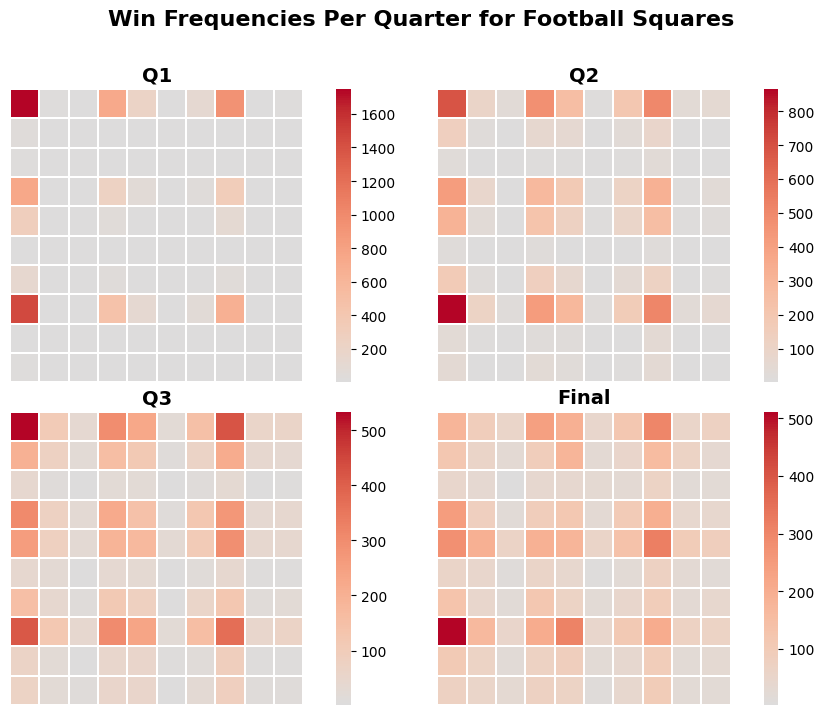

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle(title, fontsize=16, weight='bold', x=.585)



for i, ax in enumerate(axes.flatten()):
    sns.heatmap(
        frequency_matrices[i], ax=ax, cmap=cmap, center=mid_value[i], 
        cbar=True, square=True, linewidths=0.1, 
        annot=False, xticklabels=False, yticklabels=False
    )
    
    ax.set_title(quarters[i], fontsize=14, weight='bold')

    ax.spines[:].set_visible(False)
    ax.tick_params(left=False, bottom=False)

plt.subplots_adjust(top=0.88, wspace=-0.35, hspace=0.1)
print("Minamilist version")
plt.show()

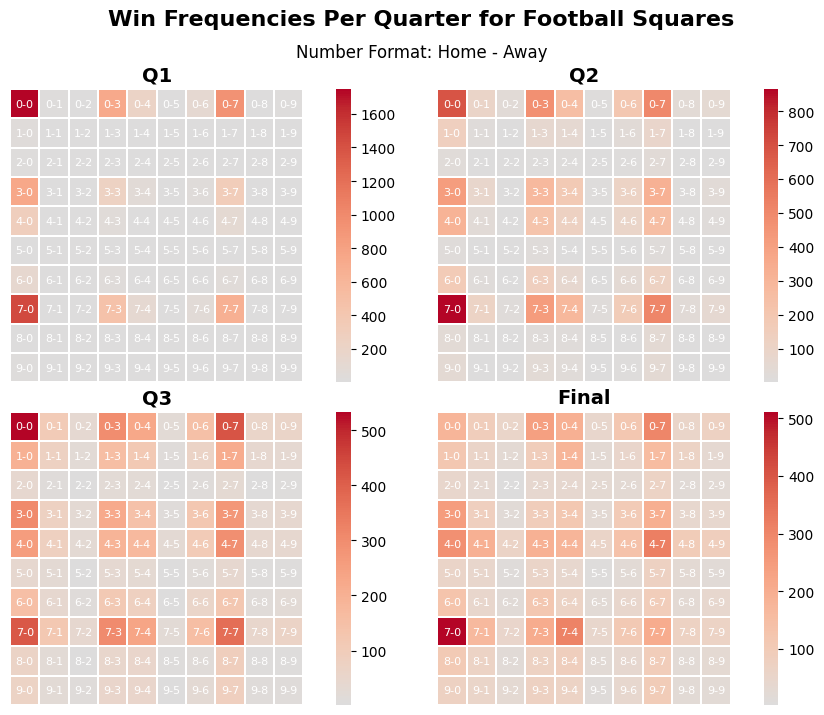

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle(title, fontsize=16, weight='bold', x=.585)

labels = np.array([[f"{y}-{x}" for x in range(10)] for y in range(10)])
single_color_cmap = ListedColormap(["#DCDBDB"])  # You can adjust this hex color as needed


for i, ax in enumerate(axes.flatten()):
    sns.heatmap(
        frequency_matrices[i], ax=ax, cmap=cmap, center=mid_value[i], 
        cbar=True, square=True, linewidths=0.1, annot=labels, fmt="s",
        xticklabels=False, yticklabels=False, annot_kws={"fontsize": 8, "alpha": 1, "color": "white"}
    )
    ax.set_title(quarters[i], fontsize=14, weight='bold')
    
    ax.spines[:].set_visible(False)
    ax.tick_params(left=False, bottom=False)

plt.figtext(0.585, 0.92, "Number Format: Home - Away", ha='center', fontsize=12)
plt.subplots_adjust(top=0.88, wspace=-0.35, hspace=0.1)
plt.show()

1. Home vs Away scoring bias: Adding the transpose of each quarter matrix to itself would remove home / away effects on scores. Then test for home vs away scoring biases. Chi-squared GOF.
 
2. Possible research question: Did any of the following NFL rule changes affect patterns in quarterly score frequencies?
- 1994: Two-point conversion allowed. We’ll need more data.
- 2010: Overtime field goal no longer wins on the first possession.
- 2011: Kickoffs moved to the 35-yard line.
- 2012: Overtime first-possession touchdowns only win if no points by the other team.
- 2015: Increased penalties for defensive fouls.
- 2018: Restrictions added to kickoffs.

Save for later: 

1. Does weather or time of day impact score frequency patterns? 
 
2. Use clustering (and possibly PCA) to investigate things like:
Quarterly scoring patterns across teams. Do some teams perform differently in different quarters?
Identify teams with similar scoring patterns. Do some teams tend to have high-scoring 4th quarters? Low-scoring first halves?

### CHI-SQUARED TESTS

In [97]:
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import cosine

def chi2_test(matrix1, matrix2):
    combined_matrix = np.vstack([matrix1.flatten(), matrix2.flatten()])
    combined_matrix += 1
    
    chi2_stat, p_value, dof, expected = chi2_contingency(combined_matrix)
    return chi2_stat, p_value, dof


df1 = games[games["year"] <= 1993].copy()
n = df1.shape[0]

df2 = games[games["year"] > 1993].copy()
df2 = df2.sample(n=n, random_state=42)

def compare(df1, df2, board_value=100):
    freq_mat1 = create_frequency_matrices(df1)
    freq_mat2 = create_frequency_matrices(df2)
    
    fv_mat1 = create_fair_value_matrices(mat=freq_mat1, board_value=board_value)
    fv_mat2 = create_fair_value_matrices(mat=freq_mat2, board_value=board_value)
    
    _, chi2_p_value_before, _= chi2_test(freq_mat1[3], freq_mat2[3])
    _, chi2_p_value_after, _= chi2_test(fv_mat1[3], fv_mat2[3])
    
    _, ks_p_value_before = ks_2samp(freq_mat1[3].flatten(), freq_mat2[3].flatten())
    _, ks_p_value_after = ks_2samp(fv_mat1[3].flatten(), fv_mat2[3].flatten())
    
    _, mw_p_value_before = mannwhitneyu(freq_mat1[3].flatten(), freq_mat2[3].flatten(), 
                                      alternative='two-sided')
    _, mw_p_value_after = mannwhitneyu(fv_mat1[3].flatten(), fv_mat2[3].flatten(), 
                                      alternative='two-sided')
    
    cosine_similarity1 = 1 - cosine(freq_mat1[3].flatten(), freq_mat2[3].flatten())
    cosine_similarity2 = 1 - cosine(fv_mat1[3].flatten(), fv_mat2[3].flatten())
    
    round_n = 6
    results = {
        "chi-squared p before": round(chi2_p_value_before, round_n),
        "chi-squared p after": round(chi2_p_value_after, round_n), 
        "ks p before": round(ks_p_value_before, round_n),
        "ks p after": round(ks_p_value_after, round_n),
        "mw p before": round(mw_p_value_before, round_n), 
        "mw p after": round(mw_p_value_after, round_n), 
        "cosine similarity before": round(cosine_similarity1, round_n),
        "cosine similarity after": round(cosine_similarity2, round_n)
        }

    return results

print(f"df1 shape: {df1.shape}, df2 shape: {df2.shape}")
res = compare(df1, df2)
res

df1 shape: (3402, 14), df2 shape: (3402, 14)


{'chi-squared p before': 0.0,
 'chi-squared p after': 1.0,
 'ks p before': 0.281942,
 'ks p after': 0.154839,
 'mw p before': 0.336788,
 'mw p after': 0.246251,
 'cosine similarity before': 0.957805,
 'cosine similarity after': 0.957805}

In [61]:
# Convert dictionary to DataFrame
df_table = pd.DataFrame([res])

# Convert DataFrame to LaTeX format and save it as a .tex file
latex_code = df_table.to_latex(index=False)
output_path = "data/results_table.tex"

# Save LaTeX code to file
with open(output_path, "w") as f:
    f.write(latex_code)

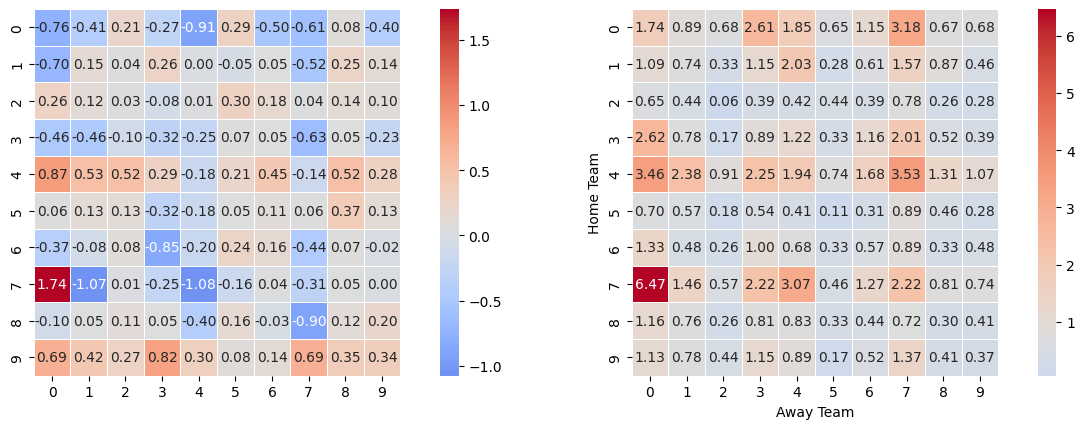

In [107]:
df1 = games[games["year"] <= 1993].copy()
df2 = games[games["year"] > 1993].copy()

freq_mat1 = create_frequency_matrices(df1)
freq_mat2 = create_frequency_matrices(df2)

fv_mat1 = create_fair_value_matrices(mat=freq_mat1, board_value=100)
fv_mat2 = create_fair_value_matrices(mat=freq_mat2, board_value=100)

diff = fv_mat2 - fv_mat1
# Heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

quarters = ['Q1', 'Q2', 'Q3', 'Final']
mid_value = np.median(diff[3])
cmap = "coolwarm"
title = "Win Frequencies Per Quarter for Football Squares"

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
sns.heatmap(diff[3], annot=True, fmt=".2f", cmap=cmap, center=mid_value,
            cbar=True, square=True, linewidths=0.5)

mid_value = np.median(fv_mat2[3])
plt.subplot(2, 2, 2)
sns.heatmap(fv_mat2[3], annot=True, fmt=".2f", cmap=cmap, center=mid_value,
            cbar=True, square=True, linewidths=0.5)
    
#plt.title(f"{quarters[i]}")
plt.xlabel("Away Team")
plt.ylabel("Home Team")
plt.subplots_adjust(top=0.88, wspace=-.25, hspace=0.1)

plt.show()